# Call ROH in more classical ways
Use a classical Method: Check for long stretches where there are is a lack of heterozygous calls

In [1]:
import allel
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
### Load the Data
h5_path_sard = "../../ancient-sardinia/output/h5/mod_reich_sardinia_ancients_mrg_dedup_3trm_anno.h5"
meta_path = "../../ancient-sardinia/output/meta/meta_final.csv"

anc_ind = 1029 # Up to which individual there are ancestrals
anc_sardind = 57 # Nr of ancient Sarinian individuals

f = h5py.File(h5_path_sard, "r") # Load for Sanity Check. See below!
list(f.keys())
print(list(f["calldata"].keys()))
print(list(f["variants"].keys()))

meta_df = pd.read_csv(meta_path)
assert(len(meta_df)==np.shape(f["calldata/GT"])[1])  # Sanity Check
### Load the SNP Data (to merge in Map):

### Helper Function, always needed 

def detect_stretches(x):
    """Detect long stretches where x=0"""
    x1 = np.hstack([ [True], x, [True] ])  # padding
    d = np.diff(x1.astype(int))
    starts = np.where(d == -1)[0]
    ends = np.where(d == 1)[0]
    return starts, ends

['AD', 'GT']
['AA', 'AF', 'AFR_AF', 'ALT', 'AMR_AF', 'CHROM', 'EAS_AF', 'EUR_AF', 'ID', 'MAP', 'POS', 'REF', 'SAS_AF']


# From Genotypte (GT) Data

In [3]:
def detect_homo(f, ind, snp_id=[]):
    """Detect two males with long ROH"""
    g = f["calldata/GT"][snp_id, ind, :]
    g = g[g[:,0]>-1]   # Only do the called Markers
    het = (g[:,0] != g[:,1])
    
    starts, ends = detect_stretches(het)   # Detect Stretches of 0s
    return starts, ends

### Do the PLINK method
def detect_homo_batch(f, ind, snp_id=[], n=50, mval=2):
    """Detect Runs of Homozygosity.
    mval: How many mismatches are allowed in windows of size n"""
    g = f["calldata/GT"][snp_id, ind, :]
    
    mc = np.where(g[:,0]>-1)[0] # Get good indices
    
    g = g[mc,:]   # Identify Markers that are called
    het = (g[:,0] != g[:,1])
    
    t = np.cumsum(het, dtype=float)
    t[n:] = (t[n:] - t[:-n])
    het_stretches = (t[n - 1:] > mval)
    
    starts, ends = detect_stretches(het_stretches)
    return mc[starts], mc[ends]  # Do the whole positions
    
def call_roh(f, ind, snp_id, min_len=50):
    """Return List of long ROH: Index1, Index"""
    print(f"Doing Ind: {ind}")
    #starts, ends = detect_homo(f, ind, snp_id)
    starts, ends = detect_homo_batch(f, ind, snp_id)
    lengths = ends - starts
    m = np.max(lengths)
    i = np.argmax(lengths)
    
    output = []
    
    if m > min_len:
        output = [[ind, m, starts[i]]]
    return output

In [4]:
ch = 20
ch_ids = np.array(f["variants/CHROM"]) == str(ch)
print(f"Found {np.sum(ch_ids)} markers on Chr. {ch}")

Found 30333 markers on Chr. 20


In [293]:
#call_roh(f, 2998, min_len=500)
ls = []

ch_ids = np.array(f["variants/CHROM"]) == str(ch)
for i in range(3050, 3080):
    ls += call_roh(f, i, ch_ids, min_len=500)

Doing Ind: 3050
Doing Ind: 3051
Doing Ind: 3052
Doing Ind: 3053
Doing Ind: 3054
Doing Ind: 3055
Doing Ind: 3056
Doing Ind: 3057
Doing Ind: 3058
Doing Ind: 3059
Doing Ind: 3060
Doing Ind: 3061
Doing Ind: 3062
Doing Ind: 3063
Doing Ind: 3064
Doing Ind: 3065
Doing Ind: 3066
Doing Ind: 3067
Doing Ind: 3068
Doing Ind: 3069
Doing Ind: 3070
Doing Ind: 3071
Doing Ind: 3072
Doing Ind: 3073
Doing Ind: 3074
Doing Ind: 3075
Doing Ind: 3076
Doing Ind: 3077
Doing Ind: 3078
Doing Ind: 3079


In [294]:
ls

[[3050, 596, 2190],
 [3054, 567, 2437],
 [3056, 841, 11399],
 [3060, 1252, 22214],
 [3066, 581, 14215],
 [3070, 617, 8712],
 [3072, 688, 11659],
 [3074, 640, 33746]]

Markers Called: 16117


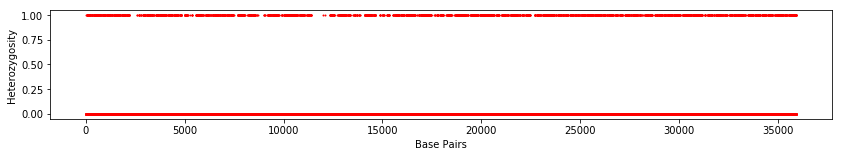

In [296]:
ind = 3056

no_call = f["calldata/GT"][ch_ids, ind, 0] > -1
print(f"Markers Called: {np.sum(no_call)}")

### Get Individual Genotype:
hets = (f["calldata/GT"][ch_ids, ind, 0] != f["calldata/GT"][ch_ids, ind, 1])

plt.figure(figsize=(14,2))
plt.xlabel("Base Pairs")
plt.ylabel("Heterozygosity")
plt.plot(hets, "ro", ms=1)
plt.show()

# Call ROH in ancients (from Read Count Data)

In [3]:
def return_conflicts(f, iid, snp_ids, min_calls = 1):
    """Return Boolean Vector of conflicting Reads"""
    ids = (meta_df["iid"] == iid)
    ids = np.where(ids)[0][0]  # Exctract the right ID
    gt = f["calldata/AD"][:, ids , :]
    gt = gt[snp_ids,:] # Extract only the good SNPs
    conf = (gt[:,0] >= min_calls) & (gt[:,1]>= min_calls)
    return conf  
    
def identify_stretch_noconfl(f, iid, snp_ids):
    """Identify Stretches with no conflicting reads
    Return Start, End and Length"""
    conf = return_conflicts(f, iid, snp_ids)
    
    x1 = np.hstack([ [True], conf, [True] ])  # padding
    d = np.diff(x1.astype(int))
    starts = np.where(d == -1)[0]
    ends = np.where(d == 1)[0]
    return starts, ends, ends - starts

### Do the PLINK Like method with Sliding Windows
def identify_stretch_noconfl_batch(f, ind, snp_ids=[], n=50, mval=2, min_calls =1):
    """Detect Runs of Homozygosity.
    mval: How many mismatches are allowed in windows of size n.
    Min_Calls: How many calls are needed for disagreement >(n,n)"""
    conf = return_conflicts(f, ind, snp_ids, min_calls)
    
    # Detect the Heterozygous Stretches
    t = np.cumsum(conf, dtype=float)
    t[n:] = (t[n:] - t[:-n])
    het_stretches = (t[n - 1:] > mval)
    
    starts, ends = detect_stretches(het_stretches)
    return starts, ends, (ends - starts)

def call_roh_readcounts(f, iid_list, ch=20, min_len=50, out=True):
    """Return List of long ROH: Index1, Index"""
    ch_ids = np.array(f["variants/CHROM"]) == str(ch)
    output = []
    l = len(iid_list)
    
    for i, iid in enumerate(iid_list):
        if out==True:
            print(f"Ind {i}/{l}: {iid}")
        starts, ends, lengths = identify_stretch_noconfl_batch(f, iid, ch_ids)
        m = np.max(lengths)
        i = np.argmax(lengths)
        
        if m > min_len:
            output += [[iid, ch, m, starts[i]]]
            
    return output

In [50]:
### Run ROH Detection for high coverage Individuals:
# Pick out High Coverage Sardinian Ancients

as_df = meta_df[:anc_sardind]
iid_list = as_df[(as_df["mean_cov"] > 1.2) & (as_df["mean_cov"] > 1.2)]["iid"].values
#iid_list = as_df[(as_df["age"] > 5000) & (as_df["mean_cov"]>0.5)]["iid"].values
#iid_list = ["MA110", "SUA002"]

### All Ancients
#as_df = meta_df[:anc_ind]
#iid_list = as_df[as_df["mean_cov"] > 1.0]["iid"].values

ls = []

#for i in range(1,23):
#    print(f"Doing Chromosome: {i}")
#    ls += call_roh_readcounts(f, iid_list, ch=i, min_len=1000) 
    
ls = call_roh_readcounts(f, iid_list, ch=1, min_len=700) 

Ind 0/30: ORC008
Ind 1/30: SUC005
Ind 2/30: SEC004
Ind 3/30: SEC002
Ind 4/30: SEC006
Ind 5/30: SEC005
Ind 6/30: ORC002
Ind 7/30: SUC009
Ind 8/30: ORC003
Ind 9/30: MA88
Ind 10/30: SUC004
Ind 11/30: MA110
Ind 12/30: SUC002
Ind 13/30: SUA001
Ind 14/30: ORC001
Ind 15/30: ORC007
Ind 16/30: ORC005
Ind 17/30: LON001
Ind 18/30: ISB001
Ind 19/30: MA89
Ind 20/30: ISC001
Ind 21/30: SEC001
Ind 22/30: SUA002
Ind 23/30: SUC003
Ind 24/30: ORC009
Ind 25/30: MA79
Ind 26/30: COR002
Ind 27/30: SUC008
Ind 28/30: COR001
Ind 29/30: ORC006


In [106]:
ls = np.array(ls)
#print(f"Long Blocks found: {len(ls)}")

In [51]:
### Uncomment to save List
#np.savetxt("../Diverse/list_roh_ancallALLChr.csv", ls, delimiter=",", fmt="%s")
ls

[['SUC005', 1, 1208, 72867],
 ['SEC004', 1, 997, 34136],
 ['SEC002', 1, 2429, 41377],
 ['SEC005', 1, 2841, 8094],
 ['ORC002', 1, 704, 31793],
 ['SUC009', 1, 723, 41720],
 ['SUC002', 1, 1121, 30257],
 ['ORC001', 1, 959, 14003],
 ['LON001', 1, 1056, 31890],
 ['SUC003', 1, 1030, 40280],
 ['ORC009', 1, 707, 27671],
 ['SUC008', 1, 868, 89193],
 ['COR001', 1, 753, 61330]]

In [192]:
meta_df[meta_df.iid.isin(ls[:, 0])].sort_values(by="age")

,iid,label,lat,lon,x_contam,mt_contam,age,study,clst_alt,period_alt,include_alt,clst,mean_cov,med_cov,n_cov_snp,full_iid
45,ORC009,Ancsard-2,39.667222,9.426111,NaN,NaN,3066.0,Marcus et al. 2018,Sar,Nur,1.0,Sar-Nur,1.880439,1.0,810727.0,ORC009.A0101.TF1.1
56,ORC006,Ancsard-2,39.667222,9.426111,0.006327,NaN,3126.0,Marcus et al. 2018,Sar,Nur,1.0,Sar-Nur,1.688213,1.0,761045.0,ORC006.A0101.TF1.1
31,ORC001,Ancsard-2,39.667222,9.426111,NaN,NaN,3153.0,Marcus et al. 2018,Sar,Nur,1.0,Sar-Nur,1.595948,1.0,771900.0,ORC001.A0101.TF1.1
16,ORC003,Ancsard-2,39.667222,9.426111,0.006596,NaN,3199.0,Marcus et al. 2018,Sar,Nur,1.0,Sar-Nur,1.881075,1.0,819347.0,ORC003.A0101.TF1.1
589,I7627,England_MBA,52.122402,-0.511365,NaN,NaN,3266.0,Olalde et al. 2018,England,MBA,1.0,GB-LBA,3.918943,2.0,771491.0,I7627
327,I9006,Mycenaean,37.970000,23.500000,NaN,NaN,3286.5,Lazaridis 2017,Mycenaean,BA,1.0,Myc-BA,1.387174,0.0,358014.0,I9006
615,I7571,England_MBA,52.340000,0.030000,NaN,NaN,3303.5,Olalde et al. 2018,England,MBA,1.0,GB-LBA,3.310995,1.0,747225.0,I7571
572,I7572,England_MBA,52.340000,0.030000,NaN,NaN,3356.0,Olalde et al. 2018,England,MBA,1.0,GB-LBA,1.193700,1.0,630315.0,I7572
339,I9041,Mycenaean,37.500000,23.450000,NaN,NaN,3400.0,Lazaridis 2017,Mycenaean,BA,1.0,Myc-BA,1.555897,0.0,410457.0,I9041
379,I7568,England_MBA,52.340000,0.030000,NaN,NaN,3400.0,Olalde et al. 2018,England,MBA,1.0,GB-LBA,3.564932,1.0,760600.0,I7568


### Plot Individual

In [45]:
def plot_roh_individual(iid, f, meta_df, ch=1, plotlim=[], cm=True, m=1, save=False):
    """Plot ROH of one Individual
    iid: Name of individual
    f: The Dataframe
    ch: Wich Chromosome
    markers: Range of Marers
    cm: Whether to Plot CentiMorgan"""
    
    ch_ids = np.array(f["variants/CHROM"]) == str(ch)
    print(f"Found {np.sum(ch_ids)} markers on Chr. {ch}")


    ids = (meta_df["iid"] == iid)
    ids = np.where(ids)[0][0] 
    
    age = meta_df["age"][ids] # Load for Plot
    clst =meta_df["clst"][ids]
    
    gt = f["calldata/AD"][ch_ids, ids, :]
    cov = np.sum(gt, axis=1) # Sum the Coverage
    mc = np.mean(cov)
    covered = np.sum(cov>0)

    print(f"Mean Coverage: {mc:.3f}")
    print(f"Covered Sites: {covered}")

    ### Conflicting Sites
    conf = (gt[:,0] >= m) & (gt[:,1]>= m)
    homo0 = (gt[:,0] >= m*2) & (gt[:,1] == 0)
    homo1 = (gt[:,1] >= m*2) & (gt[:,0] == 0)
    homo = homo0 | homo1

    diff = np.sum(conf)

    tot_cov = np.sum(gt, axis=1)
    cov2plus = (tot_cov>=m*2)

    print(f"Nr Conflicting Sites: {diff}")
    print(f"Nr No Conflicts: {np.sum(homo)}")
    print(f"Nr Sites Covered >2x: {np.sum(cov2plus)}")

    ### Do A Plot of the Conflicts
    ch_ids = np.array(f["variants/CHROM"]) == str(ch)
    print(f"Found {np.sum(ch_ids)} markers on Chr. {ch}")
    homo_ids = np.where(homo)[0]
    het_ids = np.where(conf)[0]
    cov2_ids = np.where(cov2plus)[0]

    ms = 1
    fs = 14
    
    plt.figure(figsize=(16,2))
    
    if cm==False:
        x1,x2,x3=cov2_ids, homo_ids, het_ids
    
    elif cm==True:
        lmap = np.array(f["variants/MAP"]) * 100
        lmap = lmap[ch_ids]
        assert(len(lmap)==len(homo))        
        x1,x2,x3= lmap[cov2_ids], lmap[homo_ids], lmap[het_ids]
        
    plt.plot(x1, -0.1*np.ones(len(cov2_ids)), "ko", ms=ms, label="Covered Twice")
    plt.plot(x2, np.zeros(len(homo_ids)), "ro", ms=ms, label="Agreeing")
    plt.plot(x3, np.ones(len(het_ids)), "bo", ms=ms, label="Conflicting") # The conflicting reads
    
    xlabel="Position"
    
    if cm==True:
        xlabel="CentiMorgan"
            
    plt.xlabel(xlabel, fontsize=fs)
    plt.ylabel("Conflicting Reads", fontsize=fs)
    plt.yticks([0,1])
    
    if len(plotlim)>0:
        plt.xlim(plotlim)

    plt.legend(loc = "center right", fontsize=fs)
    plt.title(f"Individual: {iid}, {age} years BP; {clst}; Chromosome: {ch}", fontsize=fs)
    
    if save==True:
        plt.savefig("../figures/" + str(iid) + "chr" + str(ch) + ".pdf", bbox_inches = 'tight', pad_inches = 0)
    plt.show()

Found 93073 markers on Chr. 1
Mean Coverage: 1.850
Covered Sites: 66456
Nr Conflicting Sites: 7113
Nr No Conflicts: 35913
Nr Sites Covered >2x: 43026
Found 93073 markers on Chr. 1


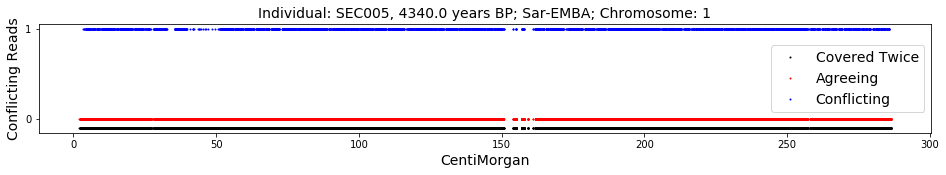

In [53]:
iid = "SEC005" #BK GOOD I3594 #BK-CE-LOOONG  #"I2597" EEBA  #MN I4435

# Which Individual to anlyze #UENO I6561 # SHG "I0011" # ArmCA "I1632"
# Iberia_ECA 

ch = 1
plot_roh_individual(iid, f, meta_df, ch=ch, plotlim=[], cm=True, m=1, save=False)

In [254]:
ch_ids = np.array(f["variants/CHROM"]) == str(15)
lmap = np.array(f["variants/MAP"]) * 100
lmap = lmap[ch_ids]
lmap[5000]

44.4359

# Area 51

In [189]:
### Merge in Recombination Map into HDF5
# Load HDF5
f = h5py.File(h5_path_sard, "r") # Load for Sanity Check. See below!
list(f.keys())
print(list(f["calldata"].keys()))
print(list(f["variants"].keys()))

# Load Recombination Map
path_snp = "../Data/1000Genomes/Markers/MinMyc.snp" # All SNPs found in the 1240k Ancient Panel

df_snp = pd.read_csv(path_snp, header=None, sep=r"\s*", engine="python")
df_snp.columns = ["SNP", "chr", "map", "pos", "ref", "alt"]
print(f"Loaded {len(df_snp)} X SNPs.")

['AD', 'GT']
['AA', 'AF', 'AFR_AF', 'ALT', 'AMR_AF', 'CHROM', 'EAS_AF', 'EUR_AF', 'ID', 'POS', 'REF', 'SAS_AF']


/usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py:2230: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py:2232: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


Loaded 1233013 X SNPs.


In [21]:
as_df = meta_df[:anc_sardind]
iid_list = as_df[(as_df["age"] > 5000) & (as_df["mean_cov"] > 0.5)]["iid"].values
iid_list

array(['MA89', 'MA79', 'SUC008'], dtype=object)

In [34]:
#as_df = meta_df[:anc_sardind]
as_df = meta_df[:anc_ind]
iid_list = as_df[as_df["mean_cov"] > 1.0]["iid"].values
print(f"Length: {len(iid_list)}")
print(f"Fraction: {(len(iid_list) / anc_ind):.5f}")

Length: 446
Fraction: 0.43343


In [236]:
meta_df[meta_df["iid"]=="I0413"]

,iid,label,lat,lon,x_contam,mt_contam,age,study,clst_alt,period_alt,include_alt,clst,mean_cov,med_cov,n_cov_snp,full_iid
1002,I0413,Europe_EN,42.5,0.5,NaN,NaN,7138.0,Lazaridis et al. 2016,Europe,EN,1.0,Iberia-EN,1.729239,1.0,678257.0,I0413


NameError: name 'anc_df' is not defined